### Questions:

The Product Manager wants to understand the following:
-	How did social login impact the number of account creations on the wishlist login page and on our checkout page?
-	How did those features compare across desktop, mobile, and tablet?
-	How did Facebook compare to Google as a social login option? 


### The Plan


1. Upload and organize the data. The datasets with "_ugid" extensions do not contain data that adds to the contents of the more plump sets so I exclude it from analysis (its upload is commented out but code is still available).
2. Visually examine "_wl" or wishlist data
    1. Examine before, test, after aggregates
        * Count on account creation
        * Rate of account creation
    2. Examine before, test, after aggregates over days to examine weekly patterns
    3. Examine before, test, after aggregates over hours to observe daily patterns
    4. Examine before, test, after aggregates by platform
    5. Examine "" by event count
    6. Examine across the social media buttons they choose
        * Counts across buttons
        * Rate of account creation
        * Rate of account creation among those who clicked on a button
3. Visually examine "_co" or checkout data
    * Follow a similar plan as outlined for "_wl"
4. Models
    1. Consider an ordinary OLS regression as benchmark
    2. Depending on results from above, I can consider both frequentist and Bayesian poisson models for the counts and logistic regression for the rates (provided the rates are not too small)

### 1. Upload and organize the data

In [1]:
##import common modules, initiate inline plotting
import os, re
import pandas as pd
import numpy as np
from matplotlib import pylab as plt
%matplotlib inline

In [2]:
##Load the data files
data_path = "C:/Users/SpiffyApple/Documents/Infrequently Accessed/Work Related/Job Applications/UncommonGoods"

#find the csv files
data_files = [x for x in os.listdir(data_path) if ".csv" in x]

#ugids_data_list = [x for x in data_files if "ugids" in x]
full_data_list = [x for x in data_files if "ugids" not in x]

In [3]:
##Load the data
#print("Number of ugids files: %d" %len(ugids_data_list))
print("Number of full data files %d" %len(full_data_list))

#convenience function to make dict keys more clean
rm_csv = lambda s: re.sub("\.csv", "", s)

def make_data_dict(dictionary, file_names, flt = None):
    if flt: 
        file_names = [x for x in file_names if flt in x]
    for f_name in file_names:
        dictionary[rm_csv(f_name)] = pd.read_csv(f_name)
    print("\navailable keys in dict\n", dictionary.keys())

#populate dictionaries with data
#ug_dict = {}; 
co_dict = {}; wl_dict = {}

#make_data_dict(ug_dict, ugids_data_list)
make_data_dict(co_dict, full_data_list, flt = 'co')
make_data_dict(wl_dict, full_data_list, flt = 'wl')

Number of full data files 6

available keys in dict
 dict_keys(['test_co', 'after_co', 'before_co'])

available keys in dict
 dict_keys(['before_wl', 'after_wl', 'test_wl'])


In [4]:
##examine the data entries
#write convenience function:
def inspct_cols(dictionary):  
    col_list = [dictionary[key].columns.tolist() for key in dictionary.keys()]
    result = set(col_list[0])
    for s in col_list[1:]:
        result.intersection_update(s)
    print("--"*20)
    print("common columns:", result)  
    diff = [set(x).difference(result) for x in col_list]
    if any(diff): [print("differing columns", d) for d in diff if d]

#inspect columns    
#inspct_cols(ug_dict)    
inspct_cols(wl_dict)
inspct_cols(co_dict)

----------------------------------------
common columns: {'_time', 'theugid', 'thedevice', 'firstpage', 'eventcount', 'isloggedin_r', 'time_hhmmss_r', 'login_or_create'}
differing columns {'themodule'}
----------------------------------------
common columns: {'_time', 'theugid', 'thedevice', 'firstpage', 'eventcount', 'reg_success'}
differing columns {'themodule'}


In [5]:
#set the 'time' as the index to make subsequent operations easier
def frmt_set_time(dictionary):
    for key in dictionary.keys():
        ##format the time to something interpretable/usable
        date_col = dictionary[key]._time.str.extract("([\d-]+)T", expand=False)
        time_col = dictionary[key]._time.str.extract("T([\d\:]+)\.\d+-", expand=False)
        dictionary[key]['time'] = pd.to_datetime(date_col+" "+time_col, format = "%Y-%m-%d %H:%M:%S")
        dictionary[key].drop("_time", inplace=True, axis=1)
        dictionary[key].set_index("time", drop=True, inplace=True)

frmt_set_time(wl_dict)
frmt_set_time(co_dict)
wl_dict['after_wl'].head(n=3)

##we can concatenate datasets
#ug_df = pd.concat(ug_dict)
wl_df = pd.concat(wl_dict)
co_df = pd.concat(co_dict)

##drop unnecessary data:
co_df.drop(['firstpage'], axis=1, inplace=True)

# 2. Examine wishlist data

In [ ]:
wl_df.head(n=2)

In [6]:
#check if length of isloggedin_r entries matches that of login_or_create
#convenience function:
get_length = lambda x: len(x.split(","))
print("All loggedin and create entries match:",all(wl_df.isloggedin_r.apply(get_length) == wl_df.login_or_create.apply(get_length)))


#check logged_in/creation cases to figure out which ones correspond to new account creation
print(wl_df.ix[3,'isloggedin_r'])
print(wl_df.ix[3,"login_or_create"])
print("--"*10)

account_created_true = wl_df.login_or_create.str.contains("C")
print(wl_df.login_or_create[account_created_true].head(n=5))

print("--"*10)
print(wl_df.ix[11,'isloggedin_r'])
print(wl_df.ix[11,"login_or_create"])

print("--"*10)
print(wl_df.ix[18,'isloggedin_r'])
print(wl_df.ix[18,"login_or_create"])

print("--"*10)
#there's potential for creating an account, logging out, then logging in
print(wl_df.login_or_create[account_created_true][-1])
print(wl_df.isloggedin_r[account_created_true][-1])

All loggedin and create entries match: True
user by-session,user by-session,user by-session,user by-session,user
N,N,N,L,N
--------------------
          time               
after_wl  2016-03-18 15:27:07      N,N,L,N,L,N,C
          2016-03-18 15:09:15      N,N,N,C,N,N,N
          2016-03-18 14:35:27    N,N,N,L,N,C,C,N
          2016-03-18 14:16:41        N,N,N,L,N,C
          2016-03-18 14:08:49        N,N,N,L,N,C
Name: login_or_create, dtype: object
--------------------
user by-session,user by-session,user by-session,user by-session,user,user,user
N,N,N,C,N,N,N
--------------------
user by-session,user by-session,user by-session,user by-session,user by-session,user by-session,user,user
N,N,N,L,N,C,C,N
--------------------
N,N,N,C,N,L,L,N,N,N
user by-session,user by-session,user by-session,user by-session,user by-session,user by-session,user,user,user,user


##### Notes on combinations in isloggedin and login_or_create fields:
1. "L,N" matched with "user by-session,user" $\implies$ logged in successfully
2. "C,N" matched with "user by-session,user" $\implies$ account was created and used
3. "L,N" matched with "user by-session, user by-session" $\implies$ login unsuccessful
4. "L,N,C" matched with "by-session,by-session,user" $\implies$ logging in unsuccesful created an account
5. "C,C,N" with "by-session, by-session, user" $\implies$ initial attempt to create dind't work, then success
6. "C" is last in sequence is ambiguous (user could've given up), **I will assume successful account creation**
7. "C,N,...L,N" matched with "session, user,...,session, user" $\implies$ user created an account, then logged into created or different account.
9. Multiple "L" would suggest that the user tried to login multiple times. I'll use this as a rough proxy for failed login attempts

##### Assumptions and implications of the above
- the above suggest that if condition "last C" or "C,N" and "by-session,user" are met then acct created 
- there is no way to see whether user clicked on "forgot" password then managed to login. Perhaps multiple sequences of "L,N" and eventual success suggests that though can't be identified.
- all "N" and "by-session" $=>$ user never tried to make account or login
- there's also potential for logging out and creating new account but I'll disregard those here
- there's potential for creating an account, logging out, then logging in
- there's potential for trying to create an account but user already has one so logging into existing but I assume it away
- tried to create an account multiple times - could be relevant if social media buttons, would decrease this hassle. I'll disregard it for now. there's much to check already

In [7]:
##use rules above to create columns respective dummy variables

##identify successful account creations
#crt1 can catch cases where "L,N" matches with "by-session, user" but "C,N" doesn't and both 
#"C,N" and "L,N" are in the string. I ignore this b/c account for this would require cumbersome code
crt1 = wl_df.login_or_create.str.contains("C,N,?", regex=True) & wl_df.isloggedin_r.str.contains("user by-session,user,?", regex=True)

c_last = lambda x: x.split(",")[-1] == 'C'
crt2 = wl_df.login_or_create.apply(c_last)

#successfully created an account
wl_df['created'] = crt1 | crt2

##logged into an existing account -accounts for Rule 7
wl_df['existing_acct'] = wl_df.login_or_create.str.contains("L,N", regex=True) & wl_df.isloggedin_r.str.contains("user by-session,user,?", regex=True) & ~wl_df['created']

#never tried to login or create
wl_df['never_acct'] = ~wl_df.login_or_create.str.contains("[L,C]+", regex=True)

#tried to login, failed then created an account -not necessary for task but good for curiosity
## the PROBLEM with this variable is that it is highly correlated with 'created' which poses issues.
wl_df['trdL_crtd'] = wl_df.login_or_create.str.contains("L,?N?(?=[C,N]+)", regex=True).astype(int) # & wl_df['created']

#tried to login multiple times => 
def mlt_l(s):
    return(len([m.start() for m in re.finditer("L",s)])>1)

wl_df['multi_L'] = wl_df.login_or_create.apply(mlt_l).astype(int)

### Caveat: from hereon, I assume that I *correctly* extracted created accounts

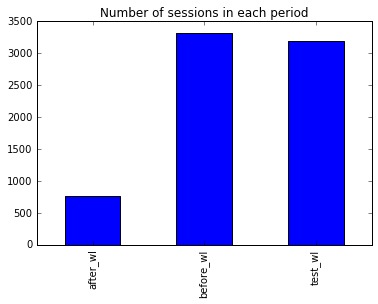


 after_wl      756
before_wl    3322
test_wl      3187
Name: eventcount, dtype: int64


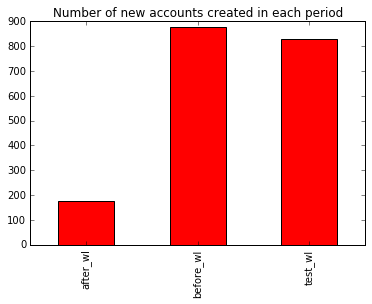


 after_wl     177.0
before_wl    876.0
test_wl      827.0
Name: created, dtype: float64


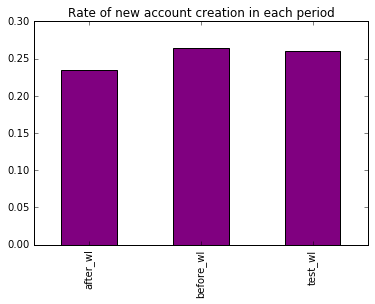


rate of new account creation
 after_wl     0.234127
before_wl    0.263697
test_wl      0.259492
dtype: float64


In [27]:
##Examine the number of sessions in each period:
wl_df.groupby(level=0).count().eventcount.plot(kind='bar')
title_s = "Number of sessions in each period"
plt.title(title_s)
plt.savefig("/".join([data_path, re.sub(" ", "", title_s)+".png"]))
plt.show()
print("\n",wl_df.groupby(level=0).count().eventcount)

wl_df.groupby(level=0).sum().created.plot(kind='bar', color = 'red')
title_s = "Number of new accounts created in each period"
plt.title(title_s)
plt.savefig("/".join([data_path, re.sub(" ", "", title_s)+".png"]))
plt.show()
print("\n",wl_df.groupby(level=0).sum().created)

##Examine the number of sessions in each period:
(wl_df.groupby(level=0).sum().created/wl_df.groupby(level=0).count().eventcount).plot(kind='bar', color='purple')
title_s = "Rate of new account creation in each period"
plt.title(title_s)
plt.savefig("/".join([data_path, re.sub(" ", "", title_s)+".png"]))
plt.show()
print("\nrate of new account creation\n", wl_df.groupby(level=0).sum().created/wl_df.groupby(level=0).count().eventcount)



### Notes:
#### Counts
1. The number of visits during the test and before sessions relatively close providing for a more or less balanced assessment (balanced is used loosely here)
2. The after period count is about $.23\approx \frac{1}{4}$th of the test count

#### Number of created accounts
1. The number of new accounts created in each period are proportional with the number of sessions.
2. The number of new accounts created in the testing phase is 49 less than created before the session. If there is a effect, it likely won't be massive.
3. The after period new account account is about $.21 \approx \frac{1}{5}$th of the test count.

#### Rate of new account creation:
1. Define $\text{rate}_t \equiv \frac{\text{# new accounts}_t }{\text{# sessions}_t}$ where $t$ indexes the time (ie period in this context)

2. The rate across the three periods is quite similar. The rate is actually smaller during the test period which is somewhat counterintuitive if we expect the social media to increase the number of created accounts.

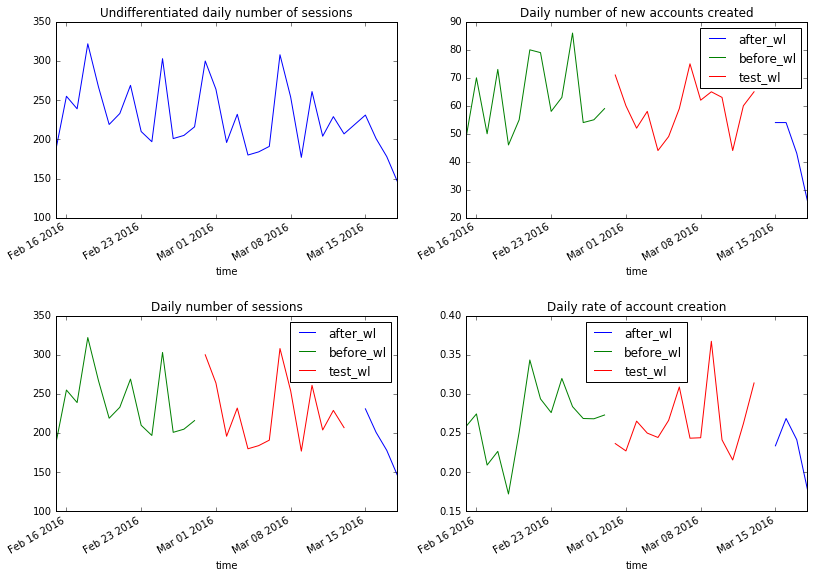

In [28]:
##Lets examine on a finer level, namely, the daily patterns
def daily_sums(group):
    return(group.reset_index(level=0, drop=True).created.resample("D").sum())

def daily_count(group):
    return(group.reset_index(level=0, drop=True).created.resample("D").count())

#counts:
daily_sums = wl_df.groupby(level=0).apply(daily_sums)
daily_counts = wl_df.groupby(level=0).apply(daily_count)

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (12,8))

daily_counts.reset_index(level=0,drop=True).plot(ax = axes[0,0])
axes[0,0].set_title("Undifferentiated daily number of sessions")
#plt.show()

daily_sums.unstack(level=0).plot(ax = axes[0,1])
axes[0,1].set_title("Daily number of new accounts created")
axes[0,1].legend(loc='best')
#plt.show()

daily_counts.unstack(level=0).plot(ax = axes[1,0])
axes[1,0].set_title("Daily number of sessions")
axes[1,0].legend(loc='best')
#plt.show()

np.divide(daily_sums.unstack(level=0), daily_counts.unstack(level=0)).plot(ax = axes[1,1])
axes[1,1].set_title("Daily rate of account creation")
axes[1,1].legend(loc='best')
#plt.show()

fig.subplots_adjust(left=.1, bottom=.1, right=.97, top=.95, wspace=.2, hspace=.5)

plt.savefig("/".join([data_path,"timeSeries_wl"+".png"]))

### Note

1. First note in the first plot: there is a trend $\implies$ data are not stationary $\implies$ traffic is systematically different between each period. This **confounds** the treatment effect and without a full year's data, or otherwise comparable untreated data during the **test** period, the treatment cannot be discerned from the cyclical effect. Superb experiment setup. 

2. *The only way to infer treatment effect from the social media buttons is to assume that there is no time trend. I'll proceed on this assumption* however data shows that it is a slippery slope. Illustration: it is possible for the new account creations to have a much lower cyclical count which was partly mitigated by the social login buttons. Though, in the data we would still see a negative impact of the social buttons despite them having helped.

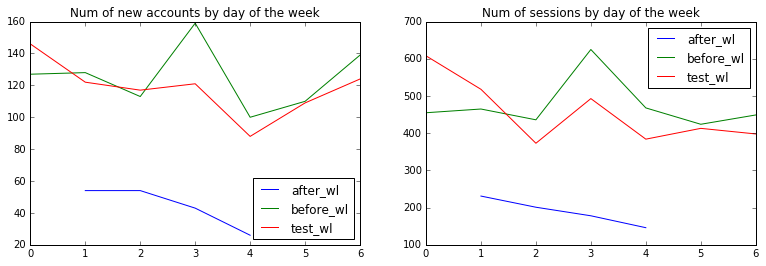

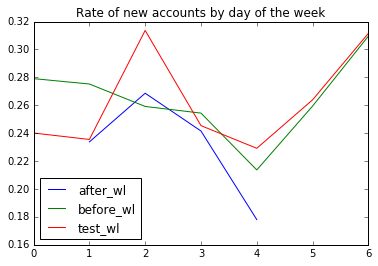

In [29]:
#lets aggregate by day of the week and plot
def weekday_sums(group):
    return(group.reset_index(level=0).groupby(lambda x: x.dayofweek).created.sum())

def weekday_count(group):
    return(group.reset_index(level=0).groupby(lambda x: x.dayofweek).created.count())
           
           
weekday_sum = wl_df.groupby(level=0).apply(weekday_sums).unstack(level=0)
weekday_count = wl_df.groupby(level=0).apply(weekday_count).unstack(level=0)
           
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (13,4))
    
weekday_sum.plot(ax = axes[0])
axes[0].legend(loc='best')
axes[0].set_title("Num of new accounts by day of the week")
#plt.show()

weekday_count.plot(ax = axes[1])
axes[1].legend(loc='best')
axes[1].set_title("Num of sessions by day of the week")
#plt.show()

#fig.subplots_adjust(left=.01, bottom=.05, right=.91, top=.93, wspace=.2, hspace=.5)

plt.savefig("/".join([data_path,"daily_timeSeries_wl_1"+".png"]))

np.divide(weekday_sum, weekday_count).plot(figsize = (6,4))
plt.legend(loc='best')
plt.title("Rate of new accounts by day of the week")
#plt.show()
plt.savefig("/".join([data_path,"daily_timeSeries_wl_2"+".png"]))


### Note

1. All days are not equal. In all of the above plots, Thursdays seem to receive the most traffic and highest number of account creations. Mondays and Sundays are the close runner ups  $\implies$ We need to take the day of the week into account. However, it is almost as if we can get away by controlling for Thursdays for the number of new accounts and thursdays, sundays for the sesssion counts. 

2. The rate of new account creation looks a bit interesting. It seems that for tests, the rate of new account creation peaks on Tuesday instead of Thursday and for both before_wl and test_wl Sundays do almost equally well. Unlike for the number data, the rate seems more volatile and it may make sense to control for all of the days. 

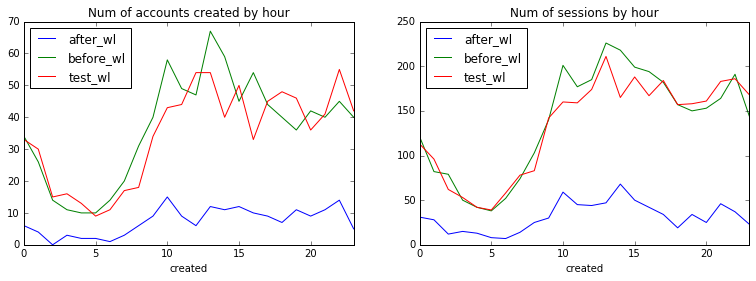

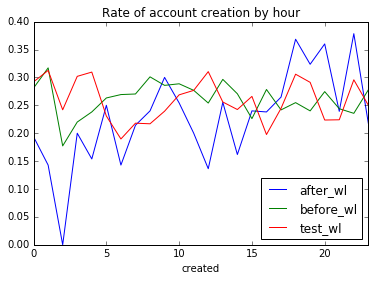

In [31]:
##lets examine hourly variations, something suggests people don't as frequently visit at 3am
#I'll attain this by aggregating over the hours. This confounds the effects of days of the week but it ought to 
#give a rough perspective

def hourly_sums(group):
    return(group.reset_index(level=0).groupby(lambda x: x.hour).created.sum())

def hourly_counts(group):
    return(group.reset_index(level=0).groupby(lambda x: x.hour).created.count())

hourly_sum = wl_df.groupby(level=0).apply(hourly_sums).transpose()
hourly_count = wl_df.groupby(level=0).apply(hourly_counts).transpose()

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (13,4))

hourly_sum.plot(ax = axes[0])
axes[0].legend(loc='best')
axes[0].set_title("Num of accounts created by hour")
#plt.show()

hourly_count.plot(ax = axes[1])
axes[1].legend(loc='best')
axes[1].set_title("Num of sessions by hour")
#plt.show()

plt.savefig("/".join([data_path,"hourly_timeSeries_wl_1"+".png"]))

np.divide(hourly_sum, hourly_count).plot(figsize = (6,4))
plt.legend(loc='best')
plt.title("Rate of account creation by hour")
#plt.show()

plt.savefig("/".join([data_path,"hourly_timeSeries_wl_2"+".png"]))

### Notes

1. As can be seen in the figures above, for both before_wl and after_wl, the number of sessions and number of new accounts track each other quite closely. 

2. The peak of activity is seems to be around 14:00 and 15:00 o'clock but it mostly plataeus. It may be possible to divide the counts into 4 or 5 parts of the day instead of 24. 
    
3. The rate of new account creation, surprisingly, remains more or less the same regardless of time.

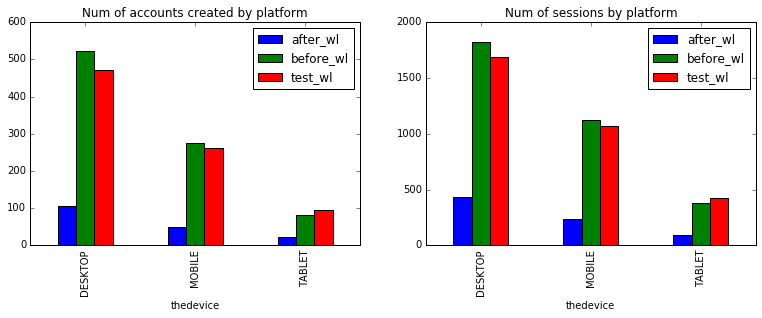

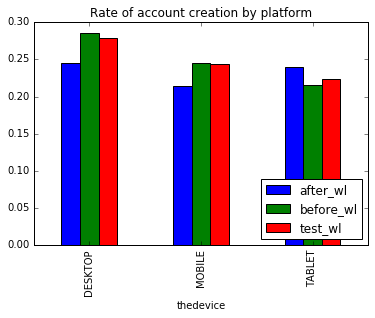

In [33]:
##finally, lets examine platform before going onto the modules
def plat_sums(group):
    return(group.reset_index(level=0).groupby("thedevice").created.sum())

def plat_count(group):
    return(group.reset_index(level=0).groupby("thedevice").created.count())

plat_sum = wl_df.groupby(level=0).apply(plat_sums).transpose()
plat_count = wl_df.groupby(level=0).apply(plat_count).transpose()

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (13,4))

plat_sum.plot(kind='bar', ax = axes[0])
axes[0].legend(loc='best')
axes[0].set_title("Num of accounts created by platform")
#plt.show()

plat_count.plot(kind='bar', ax = axes[1])
axes[1].legend(loc='best')
axes[1].set_title("Num of sessions by platform")
#plt.show()

plt.savefig("/".join([data_path,"device_wl_1"+".png"]))

np.divide(plat_sum, plat_count).plot(kind='bar',figsize = (6,4))
plt.legend(loc='lower right')
plt.title("Rate of account creation by platform")
plt.show()

plt.savefig("/".join([data_path,"device_wl_2"+".png"]))


### Notes

1. The most used platform is desktop, followed by mobile and tablet. 

2. The only platform on which the number of sessions, number of new accounts, **AND** rate increased under treatment is the tablet.

3. There doesn't seem to be much variation, patterns hold across platforms. Either way, easy to control for doesn't add too much to the feature space. 

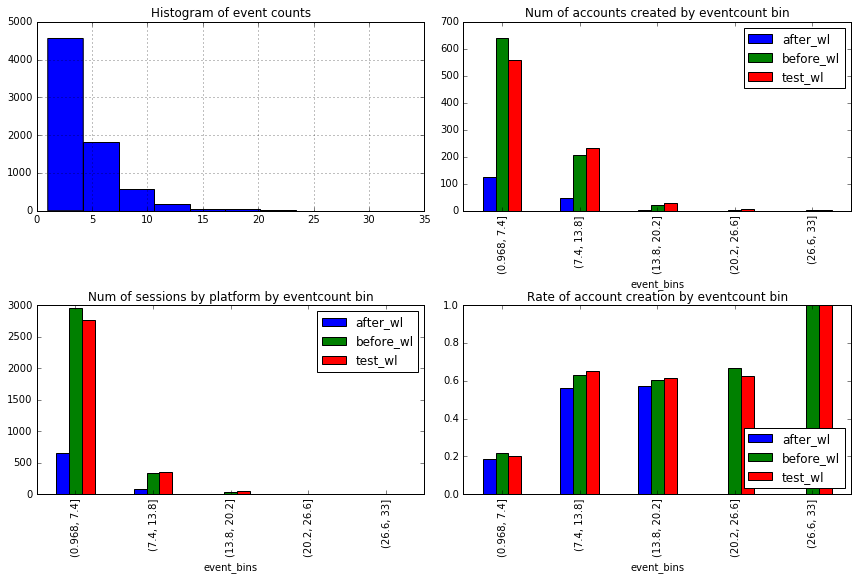

In [37]:
##just to make sure no stones are unturned, lets check out eventcount for account creation
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (13,8))

wl_df.eventcount.hist(ax= axes[0,0])
axes[0,0].set_title("Histogram of event counts")
#plt.show()

#cut the number of events into 5 bins so I can aggregate by them (more informative that simple scatter)
#could cut by quantiles though not sure i'd gain anything by that
wl_df['event_bins'] = pd.cut(wl_df.eventcount, 5)

def bin_sums(group):
    return(group.reset_index(level=0).groupby("event_bins").created.sum())

def bin_count(group):
    return(group.reset_index(level=0).groupby("event_bins").created.count())

bin_sum = wl_df.groupby(level=0).apply(bin_sums).transpose()
bin_count = wl_df.groupby(level=0).apply(bin_count).transpose()

bin_sum.plot(kind='bar', ax = axes[0,1])
axes[0,1].legend(loc='best')
axes[0,1].set_title("Num of accounts created by eventcount bin")
#plt.show()

bin_count.plot(kind='bar',ax = axes[1,0])
axes[1,0].legend(loc='best')
axes[1,0].set_title("Num of sessions by platform by eventcount bin")
#plt.show()

np.divide(bin_sum, bin_count).plot(kind='bar', ax=axes[1,1])
axes[1,1].legend(loc='lower right')
axes[1,1].set_title("Rate of account creation by eventcount bin")
#plt.show()

fig.subplots_adjust(left=.1, bottom=.15, right=.97, top=.97, wspace=.1, hspace=.5)

plt.savefig("/".join([data_path,"event_counts_wl"+".png"]))

#### Note

1. It seems that people who interact minimally with the site are not inclined to create an account, as indicated by the Rate plot. 

2. People who interact a lot with the site are highly inclined to create a new account.

3. People who interact an intermediate number of times more often than note create accounts. 

4. Thus, it seems it makes sense to control for the number of interactions, probably through bins rather than by direct counts

### The models

Although the Product Manager wants to see the effect of buttons, platform, and social media type on new account counts, and of course I will oblige, it may be desirable to make a convincing case for the rate of account creation. Consequently, I will do both. 

For the basic model, I consider the following exogenous and endogenous variables:

- *created*: dummy of whether new account has been created
- *const*: constant variable (if needed)
- *hour*:  the hour of the day of the session. Actually binned to reduce number of features.
- *day*: the day of the week of the session
- *treatment*: dummy for whether we are in test or before period
- *platform*: set of dummy variables discerning the platform of the session
- *bin*: set of dummy variables discerning the event count bins
- *button*: set of dummy variables discerning the social media button type
- *buttonxplatform*: set of button dummies crossed with platform dummies
- *trdl_crtd*: interaction term for whether the user tried to login first, then create then account with button
- *created_cnt*: number of new accounts created aggregated on an hourly basis (used for poisson regression)
- *created_rate*: rate as described above except indexed by hour and day (used in beta and poisson regression with exposure)
- *returning*: whether theugid has had sessions in the data history. In another regard, whether it's duplicated

Assumptions I make:

1. As noted far above, we **cannot** identify treatment effect because it is confounded by a time trend. Consequently, I make the extremely strong assumption that there is no seasonal trend because I cannot control for it. 
    * Interacting the social buttons with the test indicator and estimating test_wl on its own may work to control for the period effects, where *test_wl* will capture the seasonal trend while the buttons will capture their own effect.

2. I assume that the hour and day of the week variables are independent (no interaction). It is quite plausible that on Thursdays people spend more time on the website across the entire day so the hourly dynamics observed in general may not hold.

3. I assume that event count and day of the week are independent (ie no interaction). Same counter-argument as \#2. 

Let $X$ be the he models I initially consider are:

1. OLS: $E[\text{created }|X] = X\beta$ with $\varepsilon \sim N(0,1)$ and on $E[\text{Rate}|x] = X\beta$
2. Logit: $g(E(\text{created }|X)) = X\beta$ where $g$ is the logit link.
3. Poiss: $log(E(\text{created_cnt}|X)) = X\beta$ and Negative Binomial in case of over-dispersion
    * Also consider the exposure Poisson/NB model for the rate
4. Bayesian Beta Regression? thinking about it.

There are a substantial number of dummies in the model specification and we need to remove a few dummies to avoid singularities.
I drop the following dummy subsets and implicitly use those as the basis for corresponding dummy coefficients:

- "DESKTOP"(default device is "DESKTOP")
- "0"(default module is none)
- "event_bin0" (default number of events is the 1st bin) 
- "before_wl" (default period is before_wl)
- "H0" (default bin of the day is 0-3ish)
- "Mon" (default day of the week is Monday)

In [38]:
from statsmodels.tools import add_constant

#for counts
from statsmodels.discrete.discrete_model import Poisson
from statsmodels.discrete.discrete_model import NegativeBinomial

#for a bernoulli trial perspective
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Logit

#for a rate perspective
from scipy.stats import beta
#import pymc3 as pm

In [ ]:
print("Num of returning users: %d" %wl_df.theugid.duplicated().sum()) #there seem to be some return customers. Let's factor them in.

In [47]:
##make the dummy variables

#hours = pd.get_dummies(wl_df.reset_index(level=1).time.dt.hour)
hours=pd.get_dummies(pd.cut(wl_df.reset_index(level=1).time.dt.hour, bins = 8)) #bins=12))
hours.columns= ['H'+str(x) for x in range(0,hours.shape[1])]
hours.index = wl_df.index

days = pd.get_dummies(wl_df.reset_index(level=1).time.dt.dayofweek)
days.rename(columns={0:"Mon", 1:"Tu", 2:"Wed", 3: "Thu", 4:"Fri", 5:"Sat", 6:"Sun"}, inplace=True)
days.index = wl_df.index

period = pd.get_dummies(wl_df.reset_index(level=0).level_0)
period.index = wl_df.index

event_bins = pd.get_dummies(wl_df.event_bins)
event_bins.columns = ["event_bin"+str(x) for x in range(0, event_bins.shape[1])]

returning = wl_df.theugid.duplicated().astype(int)
#concatenate the dummy variables
X = pd.concat([pd.get_dummies(wl_df.thedevice), pd.get_dummies(wl_df.themodule),event_bins, period, hours,days, returning],axis=1)

##add in the remaining data:
wl_df.columns
X = pd.concat([X,wl_df[['created', 'multi_L','trdL_crtd']]], axis=1) #

X.head(n=3)

#add in interactions
#X['FxTest'] = X.F*X.test_wl
#X['GxTest'] = X.G*X.test_wl
#X['FxDesktop'] = X.DESKTOP*X.F
#X['GxF'] = X.F*X.G
X['FxMobile'] = X.MOBILE*X.F
X['GxMobile'] = X.MOBILE*X.G
X['FxTablet'] = X.TABLET*X.F
X['GxTablet'] = X.TABLET*X.G
X =add_constant(X)

In [48]:
X.columns
##drop unnecessary columns from X (to avoid singularities)

to_drop = ["DESKTOP", "0", "event_bin0", "before_wl", "H0", "Mon"]#, 'trdL_crtd']
X.drop(to_drop, axis=1, inplace=True)

X = X[X.after_wl==0]
X.drop("after_wl", axis=1, inplace=True)

#X.reset_index(drop=True, inplace=True)

y = X.created
X.drop("created", inplace=True, axis=1)

                            OLS Regression Results                            
Dep. Variable:                created   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.160
Method:                 Least Squares   F-statistic:                     43.89
Date:                Fri, 29 Jul 2016   Prob (F-statistic):          1.23e-226
Time:                        14:15:19   Log-Likelihood:                -3301.3
No. Observations:                6509   AIC:                             6663.
Df Residuals:                    6479   BIC:                             6866.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.2503      0.023     11.047      0.0

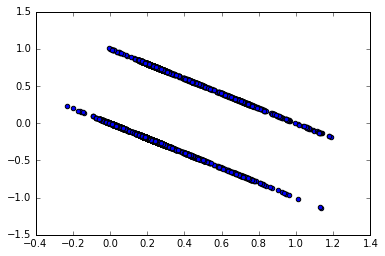

In [55]:
ols_spc1 = sm.OLS(y,X)
results=ols_spc1.fit()
print(results.summary())

plt.scatter(results.fittedvalues, results.resid)
#print(results.summary(xname = ["F", "G", "test_wl", "FxMobile", "GxMobile", "FxTablet", "GxTablet"]).as_latex())

### Notes on OLS specification 1

#### Model selection
- Interacting the social media buttons with the treatment dummy or Desktop creates singularity issues (Matrix condition number > 1e16. Consequently, I removed these from the model. 

#### Inferences from the results
In regard to variables of interest, the following conclusions are suggested by the above regression:
- Both Google and Facebook increase account creation on the desktop.
- users using tablet devices are more likely to create an account
- *test_wl* hopefully captures that seasonal trend. It is negative and significant as expected
- Returning users are less likely to create an account as expected
- People who try to login in are less likely to create an account as expected
- People are less likely to create an account on the Mobile device using social buttons
- People are not more likely to create an account on a Tablet using social media buttons than on Desktop
- Google seems to be more effective than Facebook for Desktops

In [42]:
logit_spc1 = sm.Logit(y,X.drop("event_bin4", axis=1))
logit_results = logit_spc1.fit()
print(logit_results.summary())

#plt.scatter(logit_results.fittedvalues, y)

Optimization terminated successfully.
         Current function value: 0.495026
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                created   No. Observations:                 6509
Model:                          Logit   Df Residuals:                     6480
Method:                           MLE   Df Model:                           28
Date:                Fri, 29 Jul 2016   Pseudo R-squ.:                  0.1387
Time:                        13:53:48   Log-Likelihood:                -3222.1
converged:                       True   LL-Null:                       -3741.1
                                        LLR p-value:                1.293e-200
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -1.1264      0.139     -8.089      0.000        -1.399    -0.853
MOBILE        -0.1192      0.

#### Notes on logit model
Under the same specification as the OLS model, the logit model failed to converge. This most likely occurred because in *event_bin4*, the people are $100%$ likely to create an account. This resolved the issue.

##### Inferences on the logit model:
- For the variables of interest, the same comclusions hold as those made under the OLS model. 

y mean: 2.58
y var: 3.98
	 variance is larger than mean.
y var without outliers: 3.98
sqrt(y) var: 0.51
sqrt(y) mean: 1.44
Number of new accounts: 1703
Number of sessions: 6509


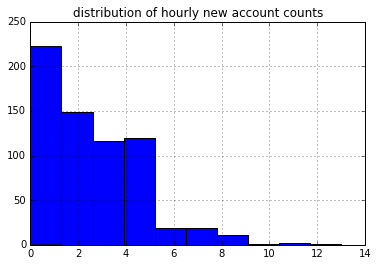

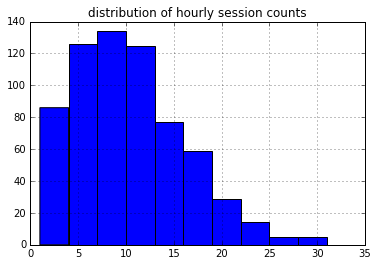

In [56]:
##aggregate counts over hourly. It makes sense for most of the data since it's almost all dummies.
X.columns

cntX = pd.concat([y,X], axis=1).reset_index(level=0, drop=True).resample("H").sum()

cntX.created.hist()
plt.title("distribution of hourly new account counts")
#looks Poisson-ish.

print("y mean: %.02f" %cntX.created.mean())
print("y var: %.02f" %cntX.created.var()) 
print("\t variance is larger than mean.")
print("y var without outliers: %.02f" %cntX.created[cntX.created<25].var()) #nope, variance is still hugely bigger.
print("sqrt(y) var: %.02f" %np.sqrt(cntX.created).var()) 
print("sqrt(y) mean: %.02f" %np.sqrt(cntX.created).mean())
#sqrt transformation doesn't quite fix the issue 
#=> NB model. though I'll still also run poisson

to_fix = ["H1", "H2", "H3", "H4", "H5", "H6", "H7", 'const', "Tu", "Wed", "Thu", "Fri", "Sat", "Sun", "test_wl"]
cntX[to_fix] = np.where(cntX[to_fix] > 0, 1, 0)

##include the number of total sessions within that period
cntX = pd.concat([cntX, wl_df.loc[['before_wl', "test_wl"]].reset_index(level=0).resample("H").count().firstpage], axis=1)
cntX.dropna(inplace=True)

#print(cntX.columns)
cntX.rename(columns = {'firstpage':"sessCnt"}, inplace=True)

plt.figure()
cntX.sessCnt.hist()
plt.title("distribution of hourly session counts")

print("Number of new accounts: %d" %cntX.created.sum())
print("Number of sessions: %d" %cntX.sessCnt.sum())

In [57]:
poiss_sp1 = sm.Poisson(cntX.created, cntX.drop(["created"], axis=1))
poiss_results = poiss_sp1.fit()

poiss_results.summary()

Optimization terminated successfully.
         Current function value: 1.609787
         Iterations 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:                created   No. Observations:                  660
Model:                        Poisson   Df Residuals:                      629
Method:                           MLE   Df Model:                           30
Date:                Fri, 29 Jul 2016   Pseudo R-squ.:                  0.2079
Time:                        14:38:54   Log-Likelihood:                -1062.5
converged:                       True   LL-Null:                       -1341.3
                                        LLR p-value:                 1.584e-98
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.0635      0.121      0.525      0.600        -0.174     0.300
MOBILE         0.0071      0.014      0.496      0.620        -0.021     0.035
TABLET         0.0058      0.020      0.297      0.766        -0.033     0.044
F             -0.0004      0.043     -0.009      0.993        -0.085     0.084
G              0.2172      0.063      3.425      0.001         0.093     0.342
event_bin1     0.1888      0.025      7.477      0.000         0.139     0.238
event_bin2     0.2157      0.058      3.694      0.000         0.101     0.330
event_bin3     0.3138      0.132      2.369      0.018         0.054     0.573
event_bin4     0.3980      0.333      1.196      0.232        -0.254     1.050
test_wl       -0.1564      0.071     -2.207      0.027        -0.295    -0.018
H1            -0.4690      0.148     -3.179      0.001        -0.758    -0.180
H2            -0.1779      0.126     -1.409      0.159        -0.425     0.070
H3             0.1310      0.109      1.202      0.229        -0.083     0.345
H4             0.1748      0.115      1.520      0.128        -0.051     0.400
H5             0.0669      0.113      0.590      0.555        -0.155     0.289
H6             0.1096      0.108      1.013      0.311        -0.103     0.322
H7             0.0980      0.110      0.890      0.374        -0.118     0.314
Tu             0.0979      0.091      1.074      0.283        -0.081     0.277
Wed            0.1677      0.097      1.730      0.084        -0.022     0.358
Thu            0.0725      0.090      0.809      0.418        -0.103     0.248
Fri           -0.0379      0.100     -0.380      0.704        -0.233     0.157
Sat            0.0397      0.098      0.406      0.685        -0.152     0.232
Sun            0.2475      0.092      2.686      0.007         0.067     0.428
theugid       -0.0781      0.020     -3.985      0.000        -0.117    -0.040
multi_L       -0.0961      0.034     -2.811      0.005        -0.163    -0.029
trdL_crtd     -0.0309      0.022     -1.389      0.165        -0.075     0.013
FxMobile       0.0467      0.072      0.651      0.515        -0.094     0.187
GxMobile      -0.1036      0.108     -0.955      0.339        -0.316     0.109
FxTablet      -0.0719      0.118     -0.607      0.544        -0.304     0.160
GxTablet      -0.0955      0.145     -0.658      0.511        -0.380     0.189
sessCnt        0.0629      0.009      6.950      0.000         0.045     0.081
==============================================================================
"""

### Notes

Assuming that the *test_wl* accounts for the time trend in the data, we can make the following conclusions:

- Unlike Facebook's button, the Google button increased the number of new accounts on Desktops
- Neither Mobile nor Tablet devices were significantly different from the Desktop in terms of hourly account creations

In [ ]:
print("Condition number of Model matrix:", np.linalg.cond( cntX.drop("created", axis=1)))
nb_sp1 = sm.NegativeBinomial(cntX.created, cntX.drop(["created"], axis=1))
nb_results = nb_sp1.fit(maxiter = 100, method='bfgs')
print("Could not make Negative Binomial converge => results are dubious? On the other hand, I tried multiple solvers, they all arrive at the same cost function value and this likelihood is convex.")
nb_results.summary()

All rates are 1 or smaller: True
                            OLS Regression Results                            
Dep. Variable:                   Rate   R-squared:                       0.188
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     5.040
Date:                Fri, 29 Jul 2016   Prob (F-statistic):           1.78e-15
Time:                        14:43:21   Log-Likelihood:                 248.97
No. Observations:                 660   AIC:                            -437.9
Df Residuals:                     630   BIC:                            -303.2
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.30

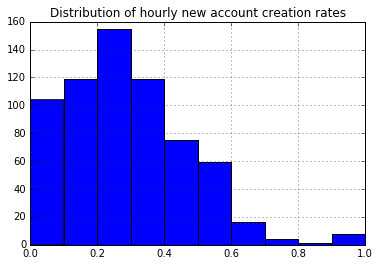

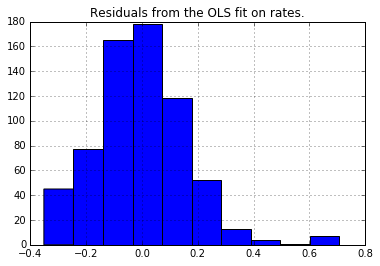

In [58]:
##Finally, let's try fitting something to the rate of account creation. 
cntX['Rate'] = np.divide(cntX.created, cntX.sessCnt)
print("All rates are 1 or smaller:", all(cntX['Rate']) <= 1)

cntX.Rate.hist()
plt.title("Distribution of hourly new account creation rates")

#can't make the poisson regression work with the "exposure" setting. 
ols_rate_results = sm.OLS(cntX['Rate'], cntX.drop(['Rate', "created", "sessCnt"], axis=1)).fit()
print(ols_rate_results.summary())

plt.figure()
ols_rate_results.resid.hist()
plt.title("Residuals from the OLS fit on rates.")


### Notes

Please note that the models above are a result of an iterative process not shown here to conserve space.

The OLS fit on the rates is actually quite good. The residuals look pretty symmetric and normal with the exception of the outlier. Consequently, I refitted the model without the outlier to see how much it changes the results. 

                            OLS Regression Results                            
Dep. Variable:                   Rate   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     5.375
Date:                Fri, 29 Jul 2016   Prob (F-statistic):           7.59e-17
Time:                        14:44:31   Log-Likelihood:                 320.72
No. Observations:                 651   AIC:                            -581.4
Df Residuals:                     621   BIC:                            -447.1
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.2977      0.026     11.536      0.0

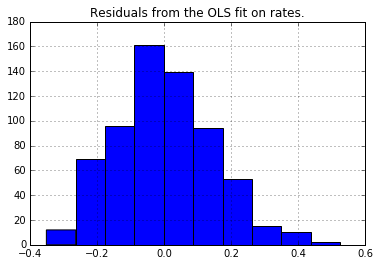

In [59]:
ols_rate_results = sm.OLS(cntX[cntX.Rate<.8]['Rate'], cntX[cntX.Rate<.8].drop(['Rate', "created", "sessCnt"], axis=1)).fit()
print(ols_rate_results.summary())

plt.figure()
ols_rate_results.resid.hist()
plt.title("Residuals from the OLS fit on rates.")

### Conclusion

- The models across the board are not robust with all of the results with the exception of the Google login option having a positive impact on account creation on the Desktop. 

- The other variables are, across most models, not statistically significant so I conclude that they do not make a difference.

### Further exploration:

- Could try to fit an ARIMA model to the "before_wl" account creation, forecast it into the "after_wl" and use the forecast as a counterfactual. 

- Could look for a structural break at the point of the social login introduction.

- Could build a Beta Regression Bayesian model but it'd be too much effort in current context.

# Checkout page results

To conserve my own time, this section very closely mirrors the Wishlist part. 

### Format and visually inspect the checkout page data

In [60]:
#drop data we do not need:
print(co_df.head(n=2))

#change the name of 'reg_success' to minimize code copying
co_df.rename(columns = {'reg_success':'created'}, inplace=True)

                              eventcount  reg_success thedevice themodule  \
         time                                                               
after_co 2016-03-18 15:33:23           1            0   DESKTOP       NaN   
         2016-03-18 15:32:55           1            0   DESKTOP       NaN   

                                              theugid  
         time                                          
after_co 2016-03-18 15:33:23  6b41f3241538abad27022f4  
         2016-03-18 15:32:55  51aab24d1538abdbb89152d  


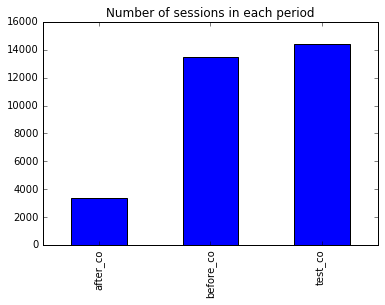

after_co      3345
before_co    13491
test_co      14427
Name: eventcount, dtype: int64


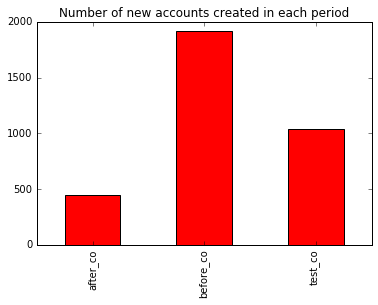

after_co      446
before_co    1921
test_co      1040
Name: created, dtype: int64


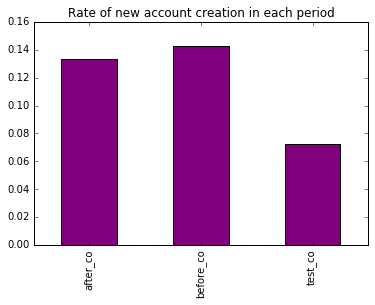


rate of new account creation
 after_co     0.133333
before_co    0.142391
test_co      0.072087
dtype: float64


In [62]:
##Examine the number of sessions in each period:
co_df.groupby(level=0).count().eventcount.plot(kind='bar')
plt.title("Number of sessions in each period")
plt.savefig("/".join([data_path, "numberofsessionsineachperiod_co.png"]))
plt.show()
print(co_df.groupby(level=0).count().eventcount)

co_df.groupby(level=0).sum().created.plot(kind='bar', color = 'red')
plt.title("Number of new accounts created in each period")
plt.savefig("/".join([data_path, "numberofnewaccountscreatedineachperiod_co.png"]))
plt.show()
print(co_df.groupby(level=0).sum().created)

##Examine the number of sessions in each period:
(co_df.groupby(level=0).sum().created/co_df.groupby(level=0).count().eventcount).plot(kind='bar', color='purple')
plt.title("Rate of new account creation in each period")
plt.savefig("/".join([data_path, "rateofnewaccountcreationineachperiod_co.png"]))
plt.show()
print("\nrate of new account creation\n", co_df.groupby(level=0).sum().created/co_df.groupby(level=0).count().eventcount)

### Notes

Unlike in the *Wishlist* data, the number of new accounts created in the test_co period has drastically smaller despite having a higher traffic rate during that period. This interestingly suggests that the social login buttons had a negative impact on account creation. 

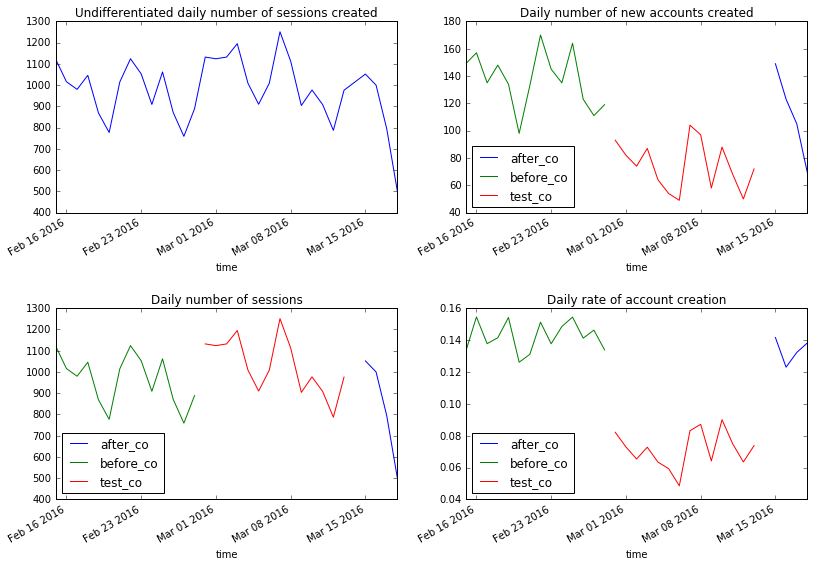

In [64]:
##Lets examine on a finer level, namely, the daily patterns
def daily_sums(group):
    return(group.reset_index(level=0, drop=True).created.resample("D").sum())

def daily_count(group):
    return(group.reset_index(level=0, drop=True).created.resample("D").count())

#counts:
daily_sums = co_df.groupby(level=0).apply(daily_sums)
daily_counts = co_df.groupby(level=0).apply(daily_count)

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (12,8))

daily_counts.reset_index(level=0,drop=True).plot(ax = axes[0,0])
axes[0,0].set_title("Undifferentiated daily number of sessions created")
#plt.show()

daily_sums.unstack(level=0).plot(ax = axes[0,1])
axes[0,1].set_title("Daily number of new accounts created")
axes[0,1].legend(loc='best')
#plt.show()

daily_counts.unstack(level=0).plot(ax = axes[1,0])
axes[1,0].set_title("Daily number of sessions")
axes[1,0].legend(loc='best')
#plt.show()

np.divide(daily_sums.unstack(level=0), daily_counts.unstack(level=0)).plot(ax = axes[1,1])
axes[1,1].set_title("Daily rate of account creation")
axes[1,1].legend(loc='best')
#plt.show()

fig.subplots_adjust(left=.1, bottom=.1, right=.97, top=.93, wspace=.2, hspace=.5)

plt.savefig("/".join([data_path, "period_aggr_co.png"]))

### Notes

- The checkout page does not seem to experience the declining trend of sessions during February.
- There is an ostensible break in the number of new accounts created between "before_wl" and "test_wl"
- The same break can be observed in the rate of account creation

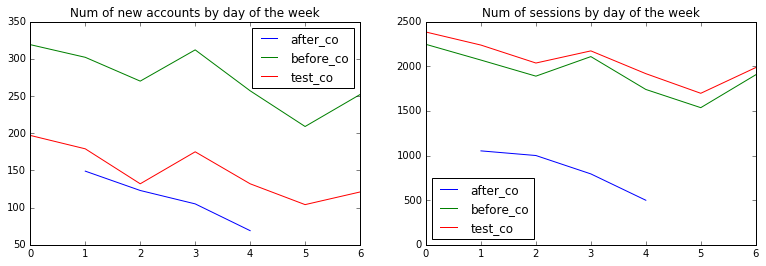

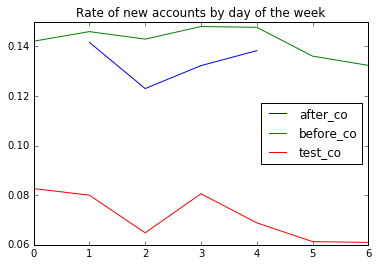

In [66]:
#lets aggregate by day of the week and plot
def weekday_sums(group):
    return(group.reset_index(level=0).groupby(lambda x: x.dayofweek).created.sum())

def weekday_count(group):
    return(group.reset_index(level=0).groupby(lambda x: x.dayofweek).created.count())
           
           
weekday_sum = co_df.groupby(level=0).apply(weekday_sums).unstack(level=0)
weekday_count = co_df.groupby(level=0).apply(weekday_count).unstack(level=0)
           
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (13,4))
    
weekday_sum.plot(ax = axes[0])
axes[0].legend(loc='best')
axes[0].set_title("Num of new accounts by day of the week")
#plt.show()

weekday_count.plot(ax = axes[1])
axes[1].legend(loc='best')
axes[1].set_title("Num of sessions by day of the week")
#plt.show()

plt.savefig("/".join([data_path,"daily_aggr_co_1.png" ])) 

#fig.subplots_adjust(left=.01, bottom=.05, right=.91, top=.93, wspace=.2, hspace=.5)

np.divide(weekday_sum, weekday_count).plot(figsize = (6,4))
plt.legend(loc='best')
plt.title("Rate of new accounts by day of the week")
#plt.show()

plt.savefig("/".join([data_path, "daily_aggr_co_2.png"]))


### Notes

- Interestingly, the "before_co" and "after_co" seem to experience the same weekly trends, albeit at different levels

- Unlike on the wishlist page, the rate does seem to experience seasonality throughout the week

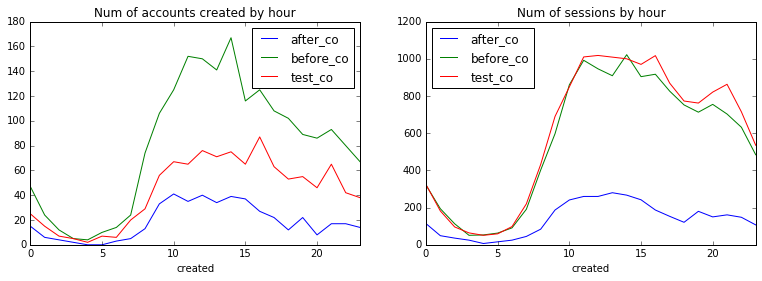

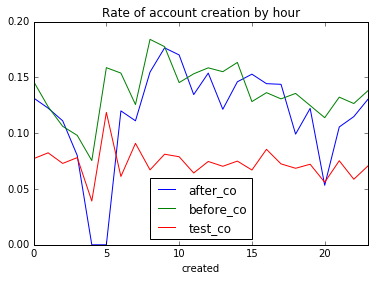

In [67]:
##lets examine hourly variations, something suggests people don't as frequently visit at 3am
#I'll attain this by aggregating over the hours. This confounds the effects of days of the week but it ought to 
#give a rough perspective

def hourly_sums(group):
    return(group.reset_index(level=0).groupby(lambda x: x.hour).created.sum())

def hourly_counts(group):
    return(group.reset_index(level=0).groupby(lambda x: x.hour).created.count())

hourly_sum = co_df.groupby(level=0).apply(hourly_sums).transpose()
hourly_count = co_df.groupby(level=0).apply(hourly_counts).transpose()

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (13,4))

hourly_sum.plot(ax = axes[0])
axes[0].legend(loc='best')
axes[0].set_title("Num of accounts created by hour")
#plt.show()

hourly_count.plot(ax = axes[1])
axes[1].legend(loc='best')
axes[1].set_title("Num of sessions by hour")
#plt.show()

fig.subplots_adjust(left=.1, bottom=.1, right=.97, top=.93, wspace=.2, hspace=.5)
plt.savefig("/".join([data_path, "hourly_aggr_co_1.png"]))

np.divide(hourly_sum, hourly_count).plot(figsize = (6,4))
plt.legend(loc='best')
plt.title("Rate of account creation by hour")
#plt.show()
            
plt.savefig("/".join([data_path, "hourly_aggr_co_2.png"]))

### Notes

- The hourly patterns are similar to the ones observed on the wishlist page, namely, activity peaks around 3pm and reaches its trough around 4am. 

- The rate doesn't experience as drastic of shifts between the hours, just like the wishlist page.

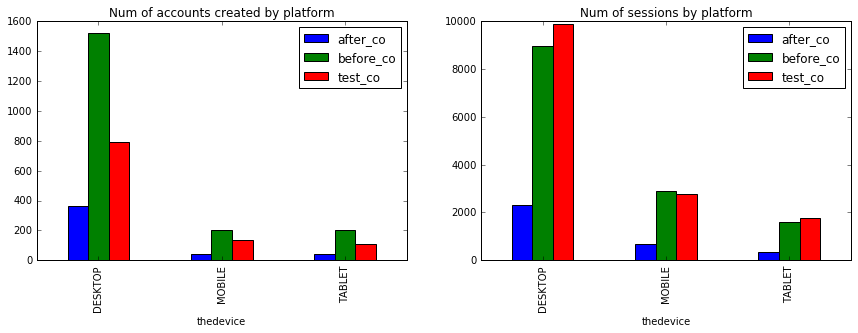

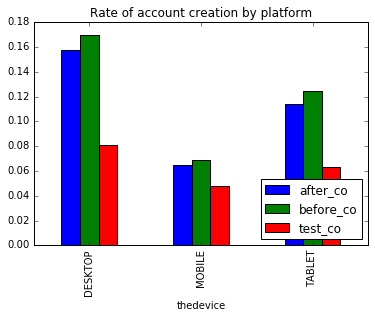

In [70]:
##finally, lets examine platform before going onto the modules
def plat_sums(group):
    return(group.reset_index(level=0).groupby("thedevice").created.sum())

def plat_count(group):
    return(group.reset_index(level=0).groupby("thedevice").created.count())

plat_sum = co_df.groupby(level=0).apply(plat_sums).transpose()
plat_count = co_df.groupby(level=0).apply(plat_count).transpose()

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (13,4))

plat_sum.plot(kind='bar', ax = axes[0])
axes[0].legend(loc='best')
axes[0].set_title("Num of accounts created by platform")
#plt.show()

plat_count.plot(kind='bar', ax = axes[1])
axes[1].legend(loc='best')
axes[1].set_title("Num of sessions by platform")
#plt.show()

fig.subplots_adjust(left=.1, bottom=.1, right=.97, top=.93, wspace=.2, hspace=.5)
plt.savefig("/".join([data_path, "device_aggr_co_1.png"]))
            
np.divide(plat_sum, plat_count).plot(kind='bar',figsize = (6,4))
plt.legend(loc='lower right')
plt.title("Rate of account creation by platform")
plt.show()
            
plt.savefig("/".join([data_path, "device_aggr_co_2.png"]))            

### Notes

- Desktop is the most frequently used device when accounts are created on the checkout page
- Mobile and Tablet have much fewer accounts created on them but they're about equal


C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:41: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


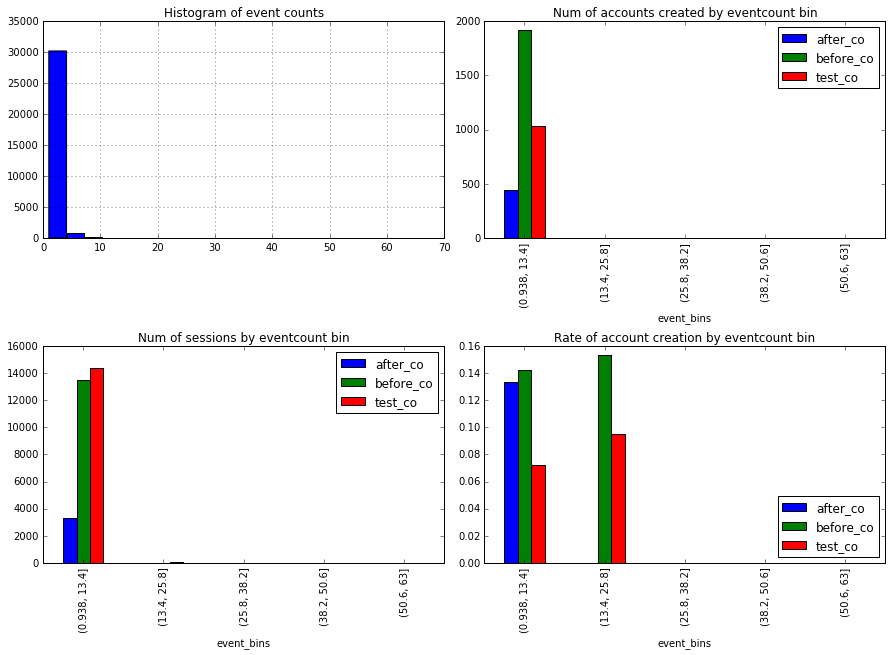

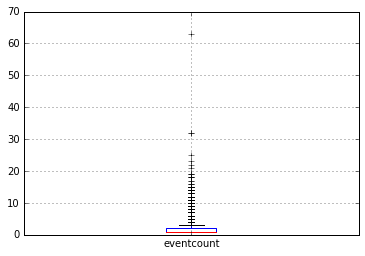

In [69]:
##just to make sure no stones are unturned, lets check out eventcount for account creation
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (13,8))

co_df.eventcount.hist(ax= axes[0,0], bins=20)
axes[0,0].set_title("Histogram of event counts")
#plt.show()

#cut the number of events into 5 bins so I can aggregate by them (more informative that simple scatter)
#could cut by quantiles though not sure i'd gain anything by that
co_df['event_bins'] = pd.cut(co_df.eventcount, 5)

def bin_sums(group):
    return(group.reset_index(level=0).groupby("event_bins").created.sum())

def bin_count(group):
    return(group.reset_index(level=0).groupby("event_bins").created.count())

bin_sum = co_df.groupby(level=0).apply(bin_sums).transpose()
bin_count = co_df.groupby(level=0).apply(bin_count).transpose()

bin_sum.plot(kind='bar', ax = axes[0,1])
axes[0,1].legend(loc='best')
axes[0,1].set_title("Num of accounts created by eventcount bin")
#plt.show()

bin_count.plot(kind='bar',ax = axes[1,0])
axes[1,0].legend(loc='best')
axes[1,0].set_title("Num of sessions by eventcount bin")
#plt.show()

np.divide(bin_sum, bin_count).plot(kind='bar', ax=axes[1,1])
axes[1,1].legend(loc='lower right')
axes[1,1].set_title("Rate of account creation by eventcount bin")
#plt.show()

fig.subplots_adjust(left=.01, bottom=.01, right=.91, top=.95, wspace=.1, hspace=.5)

plt.savefig("/".join([data_path, "event_count_co.png"]))
            
plt.figure()
_ = co_df.boxplot('eventcount', )

### Notes

- There are significantly less events in each session once visiting the checkout page. Intuitively, it makes sense, the user is done. 

- There are outliers with a lot of events after seeing the checkout page. Will likely remove the most extreme cases

### Model account creation on the checkout page

In [71]:
#remove excessive counts
co_df = co_df[co_df.eventcount<15] #arbitrary cutoff really

##make the dummy variables

#hours = pd.get_dummies(co_df.reset_index(level=1).time.dt.hour)
hours=pd.get_dummies(pd.cut(co_df.reset_index(level=1).time.dt.hour, bins = 8)) #bins=12))
hours.columns= ['H'+str(x) for x in range(0,hours.shape[1])]
hours.index = co_df.index

days = pd.get_dummies(co_df.reset_index(level=1).time.dt.dayofweek)
days.rename(columns={0:"Mon", 1:"Tu", 2:"Wed", 3: "Thu", 4:"Fri", 5:"Sat", 6:"Sun"}, inplace=True)
days.index = co_df.index

period = pd.get_dummies(co_df.reset_index(level=0).level_0)
period.index = co_df.index

event_bins = pd.get_dummies(pd.cut(co_df.eventcount, bins=5))
event_bins.columns = ["event_bin"+str(x) for x in range(0, event_bins.shape[1])]

returning = co_df.theugid.duplicated().astype(int)
#concatenate the dummy variables
X = pd.concat([pd.get_dummies(co_df.thedevice), pd.get_dummies(co_df.themodule),event_bins, period, hours,days, returning],axis=1)

##add in the remaining data:
co_df.columns
X = pd.concat([X,co_df[['created']]], axis=1)

X.head(n=3)

#add in interactions
#X['FxTest'] = X.F*X.test_wl
#X['GxTest'] = X.G*X.test_wl
#X['FxDesktop'] = X.DESKTOP*X.F
#X['GxDesktop'] = X.DESKTOP*X.G
X['FxMobile'] = X.MOBILE*X.F
X['GxMobile'] = X.MOBILE*X.G
X['FxTablet'] = X.TABLET*X.F
X['GxTablet'] = X.TABLET*X.G
X =add_constant(X)

X = X[X.after_co==0]
X.drop("after_co", axis=1, inplace=True)

In [ ]:
##get the median session counts between the two periods (before_co and after_co)
#hourly_cnts = X.loc[:,['H'+str(x) for x in range(0,hours.shape[1])]].stack().groupby(level=[0,2]).sum().groupby(level=1).median()/X.shape[0]

In [ ]:
#some interesting data acrobatics to incorporate it into X

#hourly_cnts = pd.concat([pd.DataFrame(hourly_cnts).transpose()]*X.shape[0], axis=0)

#hourly_cnts.index = X.index

#X.loc[:,['H'+str(x) for x in range(0,hours.shape[1])]] = np.multiply(X.loc[:,['H'+str(x) for x in range(0,hours.shape[1])]],hourly_cnts)

In [72]:
X.columns
##drop unnecessary columns from X (to avoid singularities)

to_drop = ["DESKTOP", "0", "event_bin0", "before_co", "H0", "Mon"]#, 'trdL_crtd']
X.drop(to_drop, axis=1, inplace=True)

In [ ]:
X.columns

### Modeling the checkout page account creations

                            OLS Regression Results                            
Dep. Variable:                created   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     66.35
Date:                Fri, 29 Jul 2016   Prob (F-statistic):               0.00
Time:                        15:32:19   Log-Likelihood:                -5852.2
No. Observations:               27892   AIC:                         1.176e+04
Df Residuals:                   27864   BIC:                         1.199e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.1746      0.010     17.938      0.0

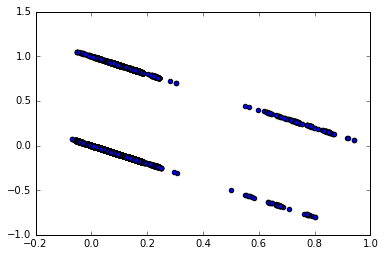

In [73]:
ols_spc1 = sm.OLS(X.created,X.drop('created', axis=1))
results=ols_spc1.fit()
print(results.summary())

plt.scatter(results.fittedvalues, results.resid)

#### Notes
The results more or less match expections inferred from the graphs:

- It seems that Mobile and Tablet users make statistically fewer new accounts on the Desktop
- The social login buttons do not significantly impact how Mobile and Tablet operate
- Both Facebook and Google buttons on the Desktop increase the chance of the user creating a new account

In [74]:
logit_spc1 = sm.Logit(X.created,X.drop("created", axis=1))
logit_results = logit_spc1.fit()
print(logit_results.summary())

Optimization terminated successfully.
         Current function value: 0.312793
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                created   No. Observations:                27892
Model:                          Logit   Df Residuals:                    27864
Method:                           MLE   Df Model:                           27
Date:                Fri, 29 Jul 2016   Pseudo R-squ.:                 0.07507
Time:                        15:35:52   Log-Likelihood:                -8724.4
converged:                       True   LL-Null:                       -9432.5
                                        LLR p-value:                7.568e-282
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -1.4499      0.107    -13.540      0.000        -1.660    -1.240
MOBILE        -0.8272      0.

### Notes
The interpretable results do not differ from the ones found under the OLS regression.

y mean: 4.43
y var: 15.93
	 variance is larger than mean.
sqrt(y) var: 1.17
sqrt(y) mean: 1.81
Number of new accounts: 2958
Number of sessions: 27892


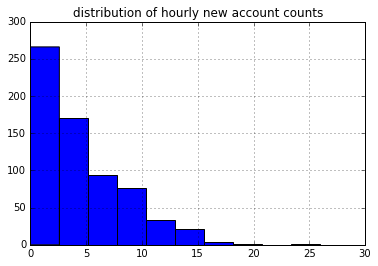

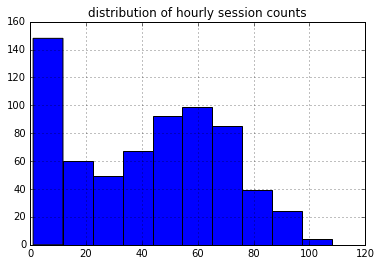

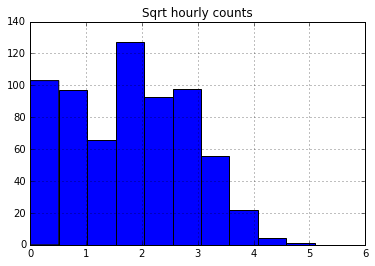

In [75]:
##modify data to hourly counts:
##aggregate counts over hourly. It makes sense for most of the data since it's almost all dummies.
X.columns

cntX = X.reset_index(level=0, drop=True).resample("H").sum()

cntX.created.hist()
plt.title("distribution of hourly new account counts")
#looks Poisson-ish.

print("y mean: %.02f" %cntX.created.mean())
print("y var: %.02f" %cntX.created.var()) 
print("\t variance is larger than mean.")
print("sqrt(y) var: %.02f" %np.sqrt(cntX.created).var()) 
print("sqrt(y) mean: %.02f" %np.sqrt(cntX.created).mean())
#sqrt transformation does fix msot of the issue. Lets work with sqrt data then
#=> NB model. though I'll still also run poisson

to_fix = ["H1", "H2", "H3", "H4", "H5", "H6", "H7", 'const', "Tu", "Wed", "Thu", "Fri", "Sat", "Sun", "test_co"]
cntX[to_fix] = np.where(cntX[to_fix] > 0, 1, 0)

##include the number of total sessions within that period
cntX = pd.concat([cntX, co_df.loc[['before_co', "test_co"]].reset_index(level=0).resample("H").count().eventcount], axis=1)
cntX.dropna(inplace=True)

#print(cntX.columns)
cntX.rename(columns = {'eventcount':"sessions"}, inplace=True)

plt.figure()
cntX.sessions.hist()
plt.title("distribution of hourly session counts")

print("Number of new accounts: %d" %cntX.created.sum())
print("Number of sessions: %d" %cntX.sessions.sum())

plt.figure()
cntX.created = np.sqrt(cntX.created)
cntX.created.hist()
plt.title("Sqrt hourly counts")

In [76]:
poiss_sp1 = sm.Poisson(cntX.created, cntX.drop(["created"], axis=1))
poiss_results = poiss_sp1.fit()

poiss_results.summary()

Optimization terminated successfully.
         Current function value: 1.277195
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:                created   No. Observations:                  667
Model:                        Poisson   Df Residuals:                      638
Method:                           MLE   Df Model:                           28
Date:                Fri, 29 Jul 2016   Pseudo R-squ.:                  0.1712
Time:                        15:37:51   Log-Likelihood:                -851.89
converged:                       True   LL-Null:                       -1027.9
                                        LLR p-value:                 1.012e-57
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -0.0181      0.144     -0.126      0.900        -0.301     0.264
MOBILE        -0.0010      0.009     -0.108      0.914        -0.018     0.016
TABLET        -0.0015      0.011     -0.139      0.889        -0.022     0.019
F              0.0613      0.074      0.832      0.406        -0.083     0.206
G              0.1248      0.095      1.312      0.190        -0.062     0.311
event_bin1     0.0033      0.019      0.174      0.862        -0.034     0.040
event_bin2    -0.0439      0.050     -0.875      0.381        -0.142     0.054
event_bin3    -0.0329      0.059     -0.562      0.574        -0.148     0.082
event_bin4     0.0946      0.113      0.840      0.401        -0.126     0.315
test_co       -0.4571      0.071     -6.417      0.000        -0.597    -0.317
H1            -0.7980      0.213     -3.749      0.000        -1.215    -0.381
H2             0.1097      0.151      0.725      0.468        -0.187     0.406
H3             0.3178      0.174      1.826      0.068        -0.023     0.659
H4             0.2865      0.190      1.512      0.131        -0.085     0.658
H5             0.2689      0.181      1.485      0.138        -0.086     0.624
H6             0.2889      0.164      1.759      0.079        -0.033     0.611
H7             0.3143      0.159      1.980      0.048         0.003     0.625
Tu             0.0534      0.105      0.508      0.612        -0.153     0.260
Wed            0.0275      0.111      0.248      0.804        -0.189     0.244
Thu            0.0358      0.104      0.344      0.731        -0.168     0.240
Fri            0.0669      0.112      0.596      0.551        -0.153     0.287
Sat           -0.0143      0.124     -0.115      0.908        -0.257     0.229
Sun           -0.0340      0.114     -0.299      0.765        -0.257     0.189
theugid       -0.0130      0.009     -1.485      0.138        -0.030     0.004
FxMobile       0.0115      0.167      0.069      0.945        -0.315     0.338
GxMobile      -0.0047      0.206     -0.023      0.982        -0.409     0.400
FxTablet       0.0542      0.206      0.264      0.792        -0.349     0.457
GxTablet      -0.0977      0.271     -0.361      0.718        -0.628     0.433
sessions       0.0147      0.004      4.079      0.000         0.008     0.022
==============================================================================
"""

### Notes

When using counts in the Poisson model, none of the conclusions we reached earlier can be made. The best predictors here seem to be the time of day and the number of sessions in that hour.



In [77]:
ols_count = sm.OLS(cntX.created, cntX.drop(["created"], axis=1))
ols_count_results = ols_count.fit()

ols_count_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                created   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.720
Method:                 Least Squares   F-statistic:                     62.08
Date:                Fri, 29 Jul 2016   Prob (F-statistic):          8.98e-162
Time:                        15:39:03   Log-Likelihood:                -559.46
No. Observations:                 667   AIC:                             1177.
Df Residuals:                     638   BIC:                             1308.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.9678      0.096     10.046      0.000         0.779     1.157
MOBILE        -0.0038      0.007     -0.506      0.613        -0.018     0.011
TABLET        -0.0074      0.009     -0.816      0.415        -0.025     0.010
F              0.0229      0.063      0.364      0.716        -0.101     0.147
G              0.1594      0.083      1.916      0.056        -0.004     0.323
event_bin1     0.0244      0.017      1.452      0.147        -0.009     0.057
event_bin2    -0.0709      0.043     -1.652      0.099        -0.155     0.013
event_bin3    -0.0508      0.050     -1.007      0.314        -0.150     0.048
event_bin4     0.2089      0.100      2.089      0.037         0.013     0.405
test_co       -0.7421      0.050    -14.776      0.000        -0.841    -0.644
H1            -0.3253      0.093     -3.496      0.001        -0.508    -0.143
H2             0.0919      0.089      1.031      0.303        -0.083     0.267
H3             0.2410      0.127      1.901      0.058        -0.008     0.490
H4             0.1870      0.144      1.299      0.194        -0.096     0.470
H5             0.0967      0.136      0.709      0.479        -0.171     0.365
H6             0.1142      0.119      0.959      0.338        -0.120     0.348
H7             0.1927      0.112      1.724      0.085        -0.027     0.412
Tu             0.0724      0.084      0.866      0.387        -0.092     0.237
Wed           -0.0178      0.085     -0.209      0.834        -0.184     0.149
Thu            0.0614      0.084      0.735      0.463        -0.103     0.225
Fri            0.0698      0.086      0.814      0.416        -0.098     0.238
Sat           -0.0587      0.090     -0.650      0.516        -0.236     0.119
Sun           -0.1008      0.087     -1.160      0.246        -0.271     0.070
theugid       -0.0349      0.008     -4.563      0.000        -0.050    -0.020
FxMobile       0.0270      0.135      0.201      0.841        -0.237     0.291
GxMobile       0.0999      0.181      0.553      0.580        -0.255     0.455
FxTablet       0.1578      0.171      0.925      0.355        -0.177     0.493
GxTablet      -0.2216      0.226     -0.981      0.327        -0.665     0.222
sessions       0.0328      0.003     10.805      0.000         0.027     0.039
==============================================================================
Omnibus:                        9.312   Durbin-Watson:                   1.806
Prob(Omnibus):                  0.010   Jarque-Bera (JB):                9.337
Skew:                          -0.287   Prob(JB):                      0.00939
Kurtosis:                       3.079   Cond. No.                         607.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is

### Notes

The ols regression paints a similar picture as the Poisson regression in terms of our parameters of interest.

                            OLS Regression Results                            
Dep. Variable:                   Rate   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                     7.681
Date:                Fri, 29 Jul 2016   Prob (F-statistic):           4.68e-25
Time:                        15:40:13   Log-Likelihood:                 880.03
No. Observations:                 656   AIC:                            -1704.
Df Residuals:                     628   BIC:                            -1578.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.1235      0.011     11.711      0.0

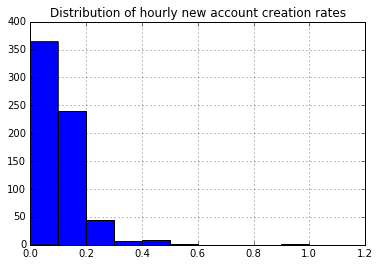

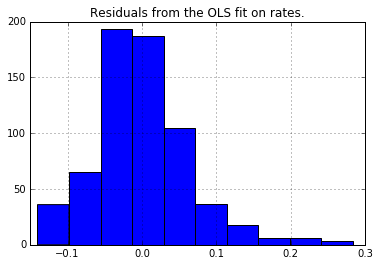

In [78]:
cntX['Rate'] = np.divide(np.square(cntX.created), cntX.sessions)

cntX.Rate.hist()
plt.title("Distribution of hourly new account creation rates")

#can't make the poisson regression work with the "exposure" setting. 
ols_rate_results = sm.OLS(cntX[cntX.Rate<.4]['Rate'], cntX[cntX.Rate<.4].drop(['Rate', "created", "sessions"], axis=1)).fit()
print(ols_rate_results.summary())

plt.figure()
ols_rate_results.resid.hist()
plt.title("Residuals from the OLS fit on rates.")

### Notes
The OLS seems to do a decent job in fitting the rate data, regardless of the presence of outliers. In the above regression, I took our rates that are higher than .4 but the results do not change. 

- Only the Google social login button the Desktop statistically improves the rate of account creation. All other parameters do not differ in a significant way.